# Importing Important Libraries

In [1]:
import pandas as pd                             
import numpy as np
#import graphviz 
import re
import nltk 
from matplotlib import pyplot
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Reading the dataset

# Working for timeline 

In [2]:
dataset=pd.read_csv("GME_augmented_processed.csv")

In [3]:
dataset['Date']=pd.to_datetime(dataset['Date'])

In [4]:
t1=pd.to_datetime(dataset['Date'][0])

In [5]:
from datetime import timedelta
dataset['Time']=t1
i=1
while i<len(dataset):
    dataset['Time'][i]=dataset['Time'][i-1]+timedelta(minutes=20) # because there are 72 values for each day, so data is 20 minutes
    i=i+1

# Data Dividing into Train, Test and Timeline

In [6]:
timeline=dataset['Time']
X=dataset.drop(["Date","Time","up"],axis=1)
y=dataset['up']

In [7]:
X_train, X_test, y_train, y_test,time_train,time_test = train_test_split(X,y,timeline,test_size=0.3,shuffle=False)


In [8]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Parameter Tuning using GridSearchCV

In [9]:
DT_model = DecisionTreeClassifier()
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
DT_model = DecisionTreeClassifier()
dtree_gscv = GridSearchCV(DT_model, param_grid, cv=3)
dtree_gscv.fit(X_train, y_train)
print("Best Parameters are: ",dtree_gscv.best_params_)

Best Parameters are:  {'criterion': 'gini', 'max_depth': 7}


# Model testing intial stage based on Parameter tuned from GridSearch

>1, Training Accuracy: 0.630, Testing Accuracy: 0.611
>2, Training Accuracy: 0.694, Testing Accuracy: 0.397
>3, Training Accuracy: 0.744, Testing Accuracy: 0.443
>4, Training Accuracy: 0.799, Testing Accuracy: 0.412


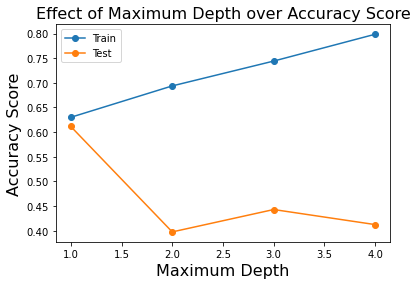

Accuracy of the Decision Tree Classification Model: 41.231422505307854
Confusion atrix of the Decision Tree Classifier

[[632 808]
 [576 339]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.52      0.44      0.48      1440
          Up       0.30      0.37      0.33       915

    accuracy                           0.41      2355
   macro avg       0.41      0.40      0.40      2355
weighted avg       0.43      0.41      0.42      2355



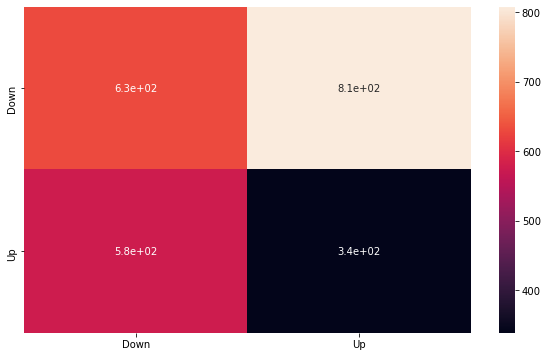

In [10]:
values = [i for i in range(1, 5)]
train_scores = list()
test_scores = list()
for i in values:
    DT_model = DecisionTreeClassifier(criterion = 'gini',max_depth=i)
    DT_model.fit(X_train, y_train)
    train_yhat = DT_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    test_yhat = DT_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    print('>%d, Training Accuracy: %.3f, Testing Accuracy: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
plt.xlabel('Maximum Depth',fontsize=16)
plt.ylabel('Accuracy Score',fontsize=16)
plt.title("Effect of Maximum Depth over Accuracy Score",fontsize=16)
pyplot.show()
y_train_pred = DT_model.predict(X_train)
DT_model_y_pred = DT_model.predict(X_test)
DT_model_accuracy  = metrics.accuracy_score(y_test, DT_model_y_pred)*100
print("Accuracy of the Decision Tree Classification Model:",DT_model_accuracy)
cm  = confusion_matrix(y_test, DT_model_y_pred)
print("Confusion atrix of the Decision Tree Classifier")
print()
target_names = ['Down', 'Up']
print(cm)
print("Classification Report of the Model")
print()
print(classification_report(y_test, DT_model_y_pred, target_names=target_names))
cm_df = pd.DataFrame(cm,target_names,target_names)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)
plt.show()

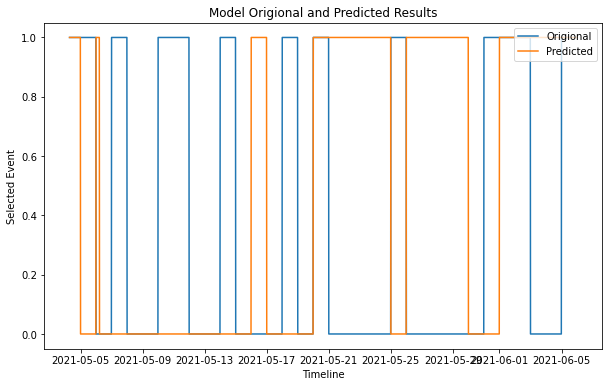

In [11]:
plt.figure(figsize=(10,6))  
plt.title('Model Origional and Predicted Results')
plt.ylabel('Selected Event')
plt.xlabel('Timeline')
plt.plot(time_test,pd.DataFrame(y_test).reset_index(drop=True).values)
plt.plot(time_test,DT_model_y_pred)
plt.legend(['Origional','Predicted'], loc='upper right')
plt.show()

# ROC Score for Intial Case

In [12]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.4727231329690347

# Tuning Maximam Depth Only

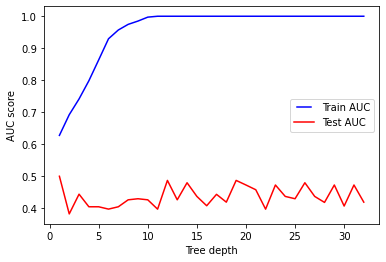

In [13]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

# Tuning Minimum Sample Splits Only

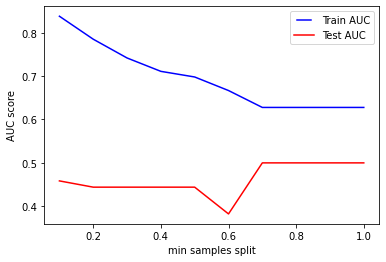

In [14]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results,'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

# Minimum Sample Leafs

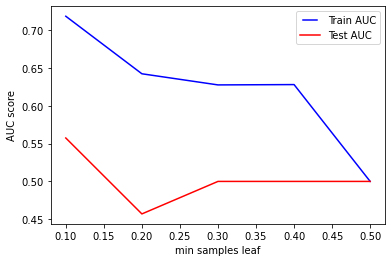

In [15]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

# A Cross Check to see if best parameter results

Accuracy of the Decision Tree Classification Model: 61.146496815286625
Confusion atrix of the Decision Tree Classifier

[[1440    0]
 [ 915    0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.61      1.00      0.76      1440
          Up       0.00      0.00      0.00       915

    accuracy                           0.61      2355
   macro avg       0.31      0.50      0.38      2355
weighted avg       0.37      0.61      0.46      2355



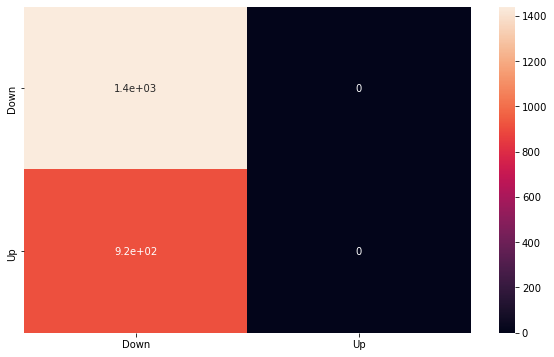

In [16]:

DT_model = DecisionTreeClassifier(criterion = 'gini',max_depth=7,min_samples_leaf=0.10,min_samples_split=0.7)
DT_model.fit(X_train, y_train)
y_train_pred = DT_model.predict(X_train)
DT_model_y_pred = DT_model.predict(X_test)
DT_model_accuracy  = metrics.accuracy_score(y_test, DT_model_y_pred)*100
print("Accuracy of the Decision Tree Classification Model:",DT_model_accuracy)
cm  = confusion_matrix(y_test, DT_model_y_pred)
print("Confusion atrix of the Decision Tree Classifier")
print()
target_names = ['Down', 'Up']
print(cm)
print("Classification Report of the Model")
print()
print(classification_report(y_test, DT_model_y_pred, target_names=target_names))
cm_df = pd.DataFrame(cm,target_names,target_names)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)
plt.show()

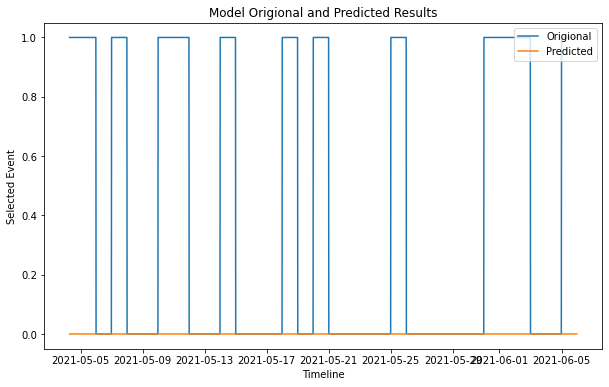

In [17]:
plt.figure(figsize=(10,6))  
plt.title('Model Origional and Predicted Results')
plt.ylabel('Selected Event')
plt.xlabel('Timeline')
plt.plot(time_test,pd.DataFrame(y_test).reset_index(drop=True).values)
plt.plot(time_test,DT_model_y_pred)
plt.legend(['Origional','Predicted'], loc='upper right')

## Cross Validation

## Based on 6 different splits


 Working for data with length:  3924 

Accuracy of the Decision Tree Classification Model: 61.120543293718164
Confusion atrix of the Decision Tree Classifier

[[720   0]
 [458   0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.61      1.00      0.76       720
          Up       0.00      0.00      0.00       458

    accuracy                           0.61      1178
   macro avg       0.31      0.50      0.38      1178
weighted avg       0.37      0.61      0.46      1178



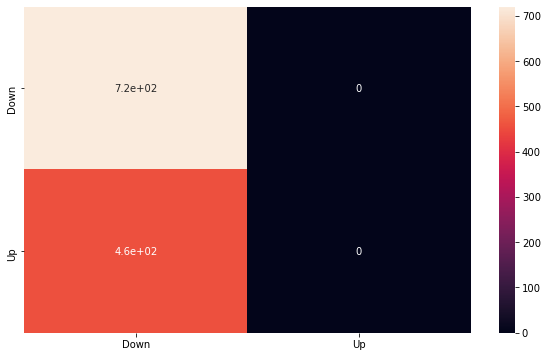

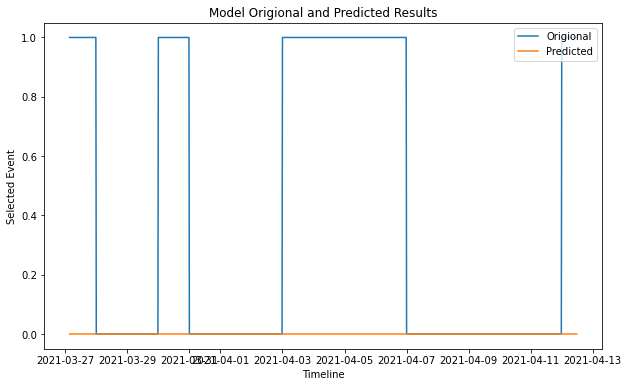


 Working for data with length:  4708 

Accuracy of the Decision Tree Classification Model: 45.85987261146497
Confusion atrix of the Decision Tree Classifier

[[648   0]
 [765   0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.46      1.00      0.63       648
          Up       0.00      0.00      0.00       765

    accuracy                           0.46      1413
   macro avg       0.23      0.50      0.31      1413
weighted avg       0.21      0.46      0.29      1413



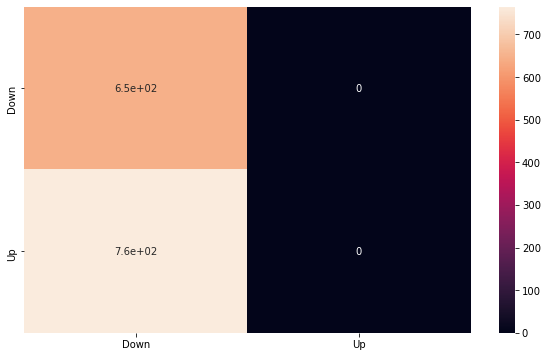

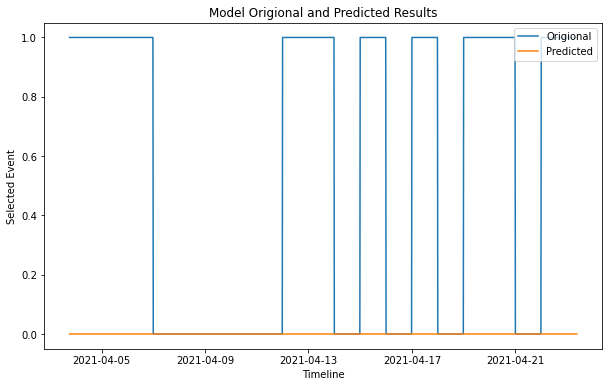


 Working for data with length:  5492 

Accuracy of the Decision Tree Classification Model: 33.25242718446602
Confusion atrix of the Decision Tree Classifier

[[ 548    0]
 [1100    0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.33      1.00      0.50       548
          Up       0.00      0.00      0.00      1100

    accuracy                           0.33      1648
   macro avg       0.17      0.50      0.25      1648
weighted avg       0.11      0.33      0.17      1648



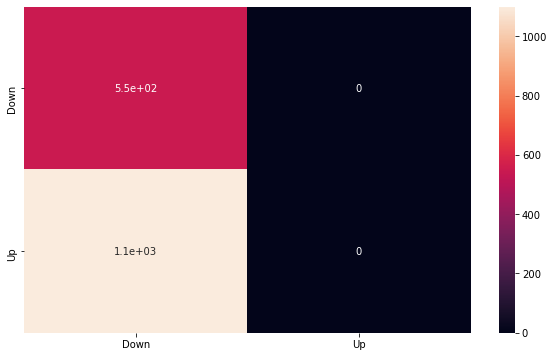

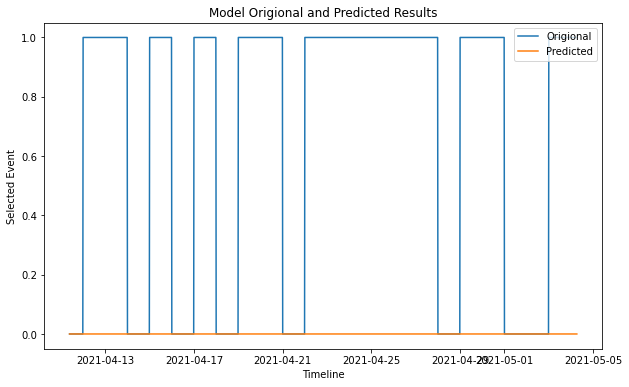


 Working for data with length:  6276 

Accuracy of the Decision Tree Classification Model: 40.73287307488051
Confusion atrix of the Decision Tree Classifier

[[ 660    0]
 [1116  107]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.37      1.00      0.54       660
          Up       1.00      0.09      0.16      1223

    accuracy                           0.41      1883
   macro avg       0.69      0.54      0.35      1883
weighted avg       0.78      0.41      0.29      1883



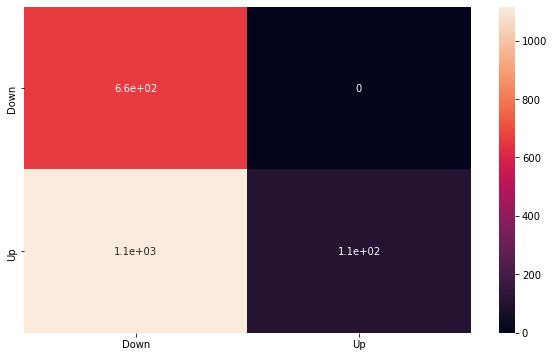

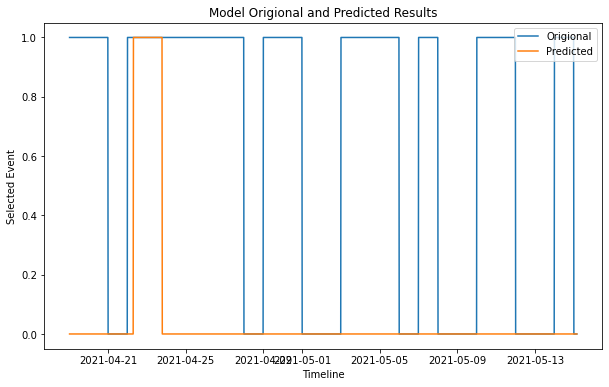


 Working for data with length:  7060 

Accuracy of the Decision Tree Classification Model: 54.57979225684608
Confusion atrix of the Decision Tree Classifier

[[1156    0]
 [ 962    0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.55      1.00      0.71      1156
          Up       0.00      0.00      0.00       962

    accuracy                           0.55      2118
   macro avg       0.27      0.50      0.35      2118
weighted avg       0.30      0.55      0.39      2118



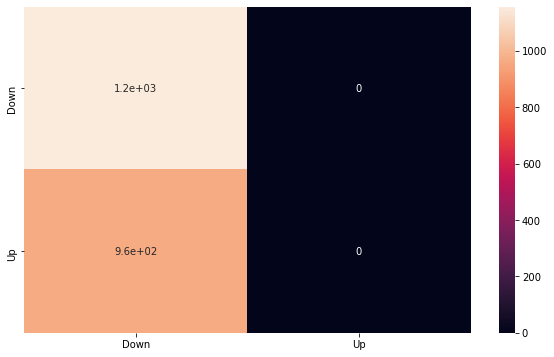

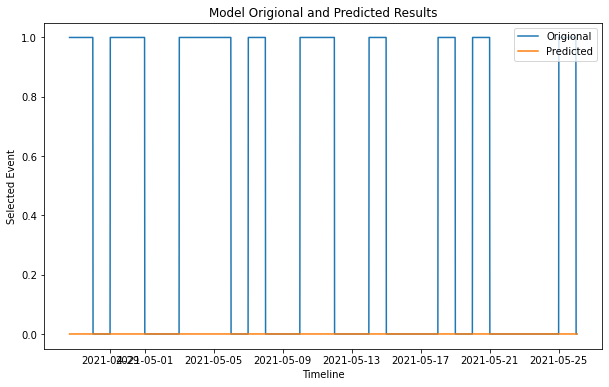


 Working for data with length:  7844 

Accuracy of the Decision Tree Classification Model: 61.17247238742566
Confusion atrix of the Decision Tree Classifier

[[1440    0]
 [ 914    0]]
Classification Report of the Model

              precision    recall  f1-score   support

        Down       0.61      1.00      0.76      1440
          Up       0.00      0.00      0.00       914

    accuracy                           0.61      2354
   macro avg       0.31      0.50      0.38      2354
weighted avg       0.37      0.61      0.46      2354



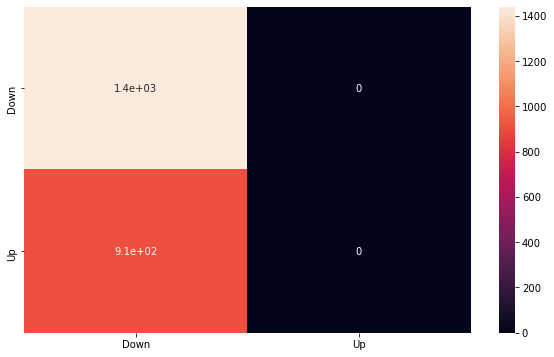

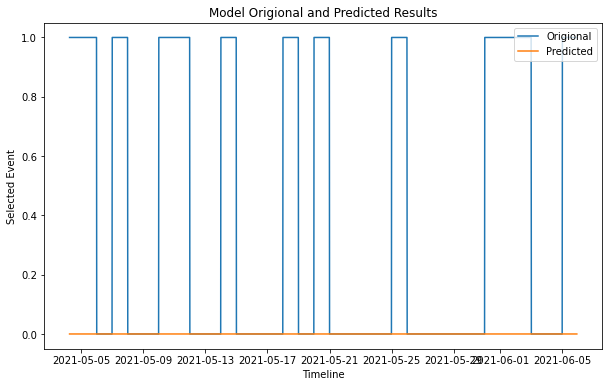

Mean Value for Area Under Curve Train: 0.6734951868099778
Mean Accuracy                   Train: 68.60700006406611
Mean Value for Area Under Curve Test : 0.5072908149359499
Mean Accuracy                   Test : 49.452996801466895


In [18]:
timeline=dataset['Time']
X=dataset.drop(["Date","Time","up"],axis=1)
y=dataset['up']
fulllength=len(dataset)
halflength=int(len(dataset)/2)
tenthpart=int(len(dataset)/10)
i=0
mean_acc=[]
mean_auc=[]
mean_acc_tr=[]
mean_auc_tr=[]
while i<6:
    X_to=X.iloc[:halflength+i*tenthpart]
    y_to=y.iloc[:halflength+i*tenthpart]
    time_to=timeline.iloc[:halflength+i*tenthpart]
    print("\n Working for data with length: ",len(X_to),"\n")
    X_train, X_test, y_train, y_test,time_train,time_test = train_test_split(X_to,y_to,time_to,test_size=0.3,shuffle=False)
    DT_model = DecisionTreeClassifier(criterion = 'gini',max_depth=7,min_samples_leaf=0.10,min_samples_split=0.7)
    DT_model.fit(X_train, y_train)
    y_train_pred = DT_model.predict(X_train)
    DT_model_y_pred = DT_model.predict(X_test)
    DT_model_accuracy  = metrics.accuracy_score(y_test, DT_model_y_pred)*100
    print("Accuracy of the Decision Tree Classification Model:",DT_model_accuracy)
    cm  = confusion_matrix(y_test, DT_model_y_pred)
    print("Confusion atrix of the Decision Tree Classifier")
    print()
    target_names = ['Down', 'Up']
    print(cm)
    print("Classification Report of the Model")
    print()
    print(classification_report(y_test, DT_model_y_pred, target_names=target_names))
    cm_df = pd.DataFrame(cm,target_names,target_names)                      
    plt.figure(figsize=(10,6))  
    sns.heatmap(cm_df, annot=True)
    plt.show()
    plt.figure(figsize=(10,6))  
    plt.title('Model Origional and Predicted Results')
    plt.ylabel('Selected Event')
    plt.xlabel('Timeline')
    plt.plot(time_test,pd.DataFrame(y_test).reset_index(drop=True).values)
    plt.plot(time_test,DT_model_y_pred)
    plt.legend(['Origional','Predicted'], loc='upper right')
    plt.show()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, DT_model_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    mean_acc.append(DT_model_accuracy)
    mean_auc.append(roc_auc)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    mean_acc_tr.append(metrics.accuracy_score(y_train, y_train_pred)*100)
    mean_auc_tr.append(roc_auc)
    i=i+1
    
print("Mean Value for Area Under Curve Train:",np.mean(mean_auc_tr))
print("Mean Accuracy                   Train:",np.mean(mean_acc_tr))
print("Mean Value for Area Under Curve Test :",np.mean(mean_auc))
print("Mean Accuracy                   Test :",np.mean(mean_acc))

In [ ]:
Mean Value for Area Under Curve Train: 0.6734951868099778
Mean Accuracy                   Train: 68.60700006406611
Mean Value for Area Under Curve Test : 0.5072908149359499
Mean Accuracy                   Test : 49.452996801466895

### Despite of choosing different splits and all parameter tuning this classification model just fails to give any testing accuracy and aur score

#### the results remains same even using the Sentiment scores and they did not effect the origional results much, the main reason behind this is there is less data for "up" and more data for "down"

#### We ran two different decision trees: one with the ohlc+technical indicator data, and one decision tree with ohlc+technical indicator data+ sentiment scores. Without sentiment data the results as following (1) value for Area Under Curve Train is  0.67, (2) Training Accuracy is 68.60, (3)Value for Area Under Curve Test is 0.50 and (4) Testing Accuracy is 49.52

#### while applying with sentiment data the results are as followed (1) value for Area Under Curve Train is  0.67, (2) Training Accuracy is 68.60, (3)Value for Area Under Curve Test is 0.50 and (4) Testing Accuracy is 49.45